## Cortical beta burst dynamics (beta power vs burst duration)
### Preprocessing

In [1]:
#import libraries and modules
import mne
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as  pd
import string
sns.set(style="white", font_scale=1)

In [2]:
# import data Medication OFF
raw = mne.io.read_raw(r'/Users/alidzaye/Charité - Universitätsmedizin Berlin/Interventional Cognitive Neuromodulation - Data/BIDS_Berlin_ECOG_LFP/rawdata/sub-003/ses-EphysMedOff01/ieeg/sub-003_ses-EphysMedOff01_task-Rest_acq-StimOff_run-01_ieeg.vhdr')
print(raw.info)

# Medication ON
raw_on = mne.io.read_raw(r'/Users/alidzaye/Charité - Universitätsmedizin Berlin/Interventional Cognitive Neuromodulation - Data/BIDS_Berlin_ECOG_LFP/rawdata/sub-003/ses-EphysMedOn01/ieeg/sub-003_ses-EphysMedOn01_task-Rest_acq-StimOff_run-01_ieeg.vhdr')
print(raw_on.info)

Extracting parameters from /Users/alidzaye/Charité - Universitätsmedizin Berlin/Interventional Cognitive Neuromodulation - Data/BIDS_Berlin_ECOG_LFP/rawdata/sub-003/ses-EphysMedOff01/ieeg/sub-003_ses-EphysMedOff01_task-Rest_acq-StimOff_run-01_ieeg.vhdr...
Setting channel info structure...
<Info | 7 non-empty values
 bads: []
 ch_names: LFP_R_1_STN_MT, LFP_R_2_STN_MT, LFP_R_3_STN_MT, LFP_R_4_STN_MT, ...
 chs: 20 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 2048.0 Hz
 meas_date: unspecified
 nchan: 20
 projs: []
 sfreq: 4096.0 Hz
>
Extracting parameters from /Users/alidzaye/Charité - Universitätsmedizin Berlin/Interventional Cognitive Neuromodulation - Data/BIDS_Berlin_ECOG_LFP/rawdata/sub-003/ses-EphysMedOn01/ieeg/sub-003_ses-EphysMedOn01_task-Rest_acq-StimOff_run-01_ieeg.vhdr...
Setting channel info structure...
<Info | 7 non-empty values
 bads: []
 ch_names: LFP_R_1_STN_MT, LFP_R_2_STN_MT, LFP_R_3_STN_MT, LFP_R_4_STN_MT, ...
 chs: 14 EEG
 custom_ref_applied: False
 h

In [64]:
# pick ecog channels
raw_ecog = raw.copy().pick_channels(raw.ch_names[10:16])
raw_ecog_on = raw_on.copy().pick_channels(raw_on.ch_names[8:15])

In [8]:
# switch channel type into ECoG 
#raw_ecog.set_channel_types({ch: 'ecog' for ch in raw.ch_names if 'ECOG' in ch})
#raw_ecog_on.set_channel_types({ch: 'ecog' for ch in raw_on.ch_names if 'ECOG' in ch})

<RawBrainVision | sub-003_ses-EphysMedOn01_task-Rest_acq-StimOff_run-01_ieeg.eeg, 6 x 1729554 (422.3 s), ~11 kB, data not loaded>

In [9]:
# bipolar re-reference
new_ch_names = ['ECOG_L_1_SMC_BI',
               'ECOG_L_2_SMC_BI',
               'ECOG_L_3_SMC_BI',
               'ECOG_L_4_SMC_BI',
              'ECOG_L_5_SMC_BI']
anode = raw_ecog.ch_names[0:5]
cathode = raw_ecog.ch_names[1:6]
raw_ecog_bi = mne.set_bipolar_reference(raw_ecog.load_data(), anode=anode,
                                        cathode=cathode, ch_name=new_ch_names )

anode_on = raw_ecog_on.ch_names[0:5]
cathode_on = raw_ecog_on.ch_names[1:6]
raw_ecog_bi_on = mne.set_bipolar_reference(raw_ecog_on.load_data(), anode=anode_on,
                                        cathode=cathode_on, ch_name=new_ch_names )

Reading 0 ... 2536497  =      0.000 ...   619.262 secs...
ECoG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=5, n_times=2536498
    Range : 0 ... 2536497 =      0.000 ...   619.262 secs
Ready.
Added the following bipolar channels:
ECOG_L_1_SMC_BI, ECOG_L_2_SMC_BI, ECOG_L_3_SMC_BI, ECOG_L_4_SMC_BI, ECOG_L_5_SMC_BI
Reading 0 ... 1729553  =      0.000 ...   422.254 secs...
ECoG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=5, n_times=1729554
    Range : 0 ... 1729553 =      0.000 ...   422.254 secs
Ready.
Added the following bipolar channels:
ECOG_L_1_SMC_BI, ECOG_L_2_SMC_BI, ECOG_L_3_SMC_BI, ECOG_L_4_SMC_BI, ECOG_L_5_SMC_BI


In [10]:
# Filtering (HP 3, NF 50,251,50, LP 250)
raw_ecog_hi = raw_ecog_bi.copy().filter(3, None,)
raw_ecog_hi_lo = raw_ecog_hi.copy().filter(None, 250)
raw_ecog_hi_lo_nf = raw_ecog_hi_lo.copy().notch_filter(np.arange(50,251,50), filter_length="auto", phase='zero')

raw_ecog_hi_on = raw_ecog_bi_on.copy().filter(3, None,)
raw_ecog_hi_lo_on = raw_ecog_hi_on.copy().filter(None, 250)
raw_ecog_hi_lo_nf_on = raw_ecog_hi_lo_on.copy().notch_filter(np.arange(50,251,50), filter_length="auto", phase='zero')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Filter length: 6759 samples (1.650 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 62.50 Hz (-6 dB cutoff frequency: 281.25 Hz)
- Filter length: 217 samples (0.053 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a on

### Artefact Detection

In [11]:
# plot filtered ecog channels for annotiations
%matplotlib qt
raw_ecog_hi_lo_nf.plot(scalings='auto', highpass=3, lowpass=95, decim='auto')

In [ ]:
raw_ecog_hi_lo_nf.annotations

In [ ]:
raw_ecog_hi_lo_nf.annotations.save('run.txt', overwrite=True)

In [12]:
#raw_ecog_hi_lo_nf_on.plot(scalings='auto', highpass=3, lowpass=95, decim='auto')

In [13]:
#Cropping the last bit of data to ignore artefacts at the end
raw_ecog_cropped = raw_ecog_hi_lo_nf.copy().crop(tmax=618)
raw_ecog_cropped_on = raw_ecog_hi_lo_nf_on.copy().crop(tmax=420)

In [14]:
#Downsample Data to 250Hz for faster processing
raw_ecog_dow = raw_ecog_cropped.copy().resample(250)
raw_ecog_dow_on = raw_ecog_cropped_on.copy().resample(250)

In [15]:
# get the data with the function
signal = raw_ecog_dow.copy().get_data()
signal_on = raw_ecog_dow_on.copy().get_data()
print(signal.shape)

(5, 154500)


In [16]:
#z-score the data
stand_raw_ecog = stats.zscore(signal, axis=1)
stand_raw_ecog_on = stats.zscore(signal_on, axis=1)
print(stand_raw_ecog)

[[ 0.00738791  0.21930132  0.315697   ... -1.84930798  0.49409292
   0.22580868]
 [-0.02928701 -0.05977788  0.63190585 ...  1.39914355 -0.18708758
  -0.12265251]
 [ 0.0205305  -0.18472876 -1.42770698 ... -1.63299962  0.776301
   1.24031433]
 [ 0.06941612  1.27686861  2.43283879 ... -0.30369502 -0.10111857
   0.22116871]
 [-0.0724597  -1.23678535 -2.12180955 ... -0.28349491 -0.58660712
  -0.50319248]]


In [17]:
#Time Frequency estimation
freqs = np.arange(1,100)
power = mne.decoding.TimeFrequency(freqs, sfreq=250, method='morlet', n_cycles=10, output='power', )
run_TF = power.transform(stand_raw_ecog)
run_TF_on = power.transform(stand_raw_ecog_on)
run_TF.shape

(5, 99, 154500)

### Beta bands of the ecog channels: low beta(13-20Hz), high beta (20-35Hz), full beta (13-35Hz)

In [18]:
low_beta_1 = run_TF[0, 12:20,:]
high_beta_1 = run_TF[0, 19:35,:]
full_beta_1 = run_TF[0, 12:35,:]

low_beta_2 = run_TF[1, 12:20,:]
high_beta_2 = run_TF[1, 19:35,:]
full_beta_2 = run_TF[1, 12:35,:]

low_beta_3 = run_TF[2, 12:20,:]
high_beta_3 = run_TF[2, 19:35,:]
full_beta_3 = run_TF[2, 12:35,:]

low_beta_4 = run_TF[3, 12:20,:]
high_beta_4 = run_TF[3, 19:35,:]
full_beta_4 = run_TF[3, 12:35,:]

low_beta_5 = run_TF[4, 12:20,:]
high_beta_5 = run_TF[4, 19:35,:]
full_beta_5 = run_TF[4, 12:35,:]

#ON
low_beta_1_on = run_TF_on[0, 12:20,:]
high_beta_1_on = run_TF_on[0, 19:35,:]
full_beta_1_on = run_TF_on[0, 12:35,:]

low_beta_2_on = run_TF_on[1, 12:20,:]
high_beta_2_on = run_TF_on[1, 19:35,:]
full_beta_2_on = run_TF_on[1, 12:35,:]

low_beta_3_on = run_TF_on[2, 12:20,:]
high_beta_3_on = run_TF_on[2, 19:35,:]
full_beta_3_on = run_TF_on[2, 12:35,:]

low_beta_4_on = run_TF_on[3, 12:20,:]
high_beta_4_on = run_TF_on[3, 19:35,:]
full_beta_4_on = run_TF_on[3, 12:35,:]


low_beta_5_on = run_TF_on[4, 12:20,:]
high_beta_5_on = run_TF_on[4, 19:35,:]
full_beta_5_on = run_TF_on[4, 12:35,:]

full_beta_4.shape

(23, 154500)

### Averaging power in all beta bands 

In [19]:
low_beta_1_averp = np.mean(low_beta_1, axis=0)
high_beta_1_averp = np.mean(high_beta_1, axis=0)
full_beta_1_averp = np.mean(full_beta_1, axis=0)

low_beta_2_averp = np.mean(low_beta_2, axis=0)
high_beta_2_averp = np.mean(high_beta_2, axis=0)
full_beta_2_averp = np.mean(full_beta_2, axis=0)

low_beta_3_averp = np.mean(low_beta_3, axis=0)
high_beta_3_averp = np.mean(high_beta_3, axis=0)
full_beta_3_averp = np.mean(full_beta_3, axis=0)

low_beta_4_averp = np.mean(low_beta_4, axis=0)
high_beta_4_averp = np.mean(high_beta_4, axis=0)
full_beta_4_averp = np.mean(full_beta_4, axis=0)

low_beta_5_averp = np.mean(low_beta_5, axis=0)
high_beta_5_averp = np.mean(high_beta_5, axis=0)
full_beta_5_averp = np.mean(full_beta_5, axis=0)

#ON
low_beta_1_averp_on = np.mean(low_beta_1_on, axis=0)
high_beta_1_averp_on = np.mean(high_beta_1_on, axis=0)
full_beta_1_averp_on = np.mean(full_beta_1_on, axis=0)

low_beta_2_averp_on = np.mean(low_beta_2_on, axis=0)
high_beta_2_averp_on = np.mean(high_beta_2_on, axis=0)
full_beta_2_averp_on = np.mean(full_beta_2_on, axis=0)

low_beta_3_averp_on = np.mean(low_beta_3_on, axis=0)
high_beta_3_averp_on = np.mean(high_beta_3_on, axis=0)
full_beta_3_averp_on = np.mean(full_beta_3_on, axis=0)

low_beta_4_averp_on = np.mean(low_beta_4_on, axis=0)
high_beta_4_averp_on = np.mean(high_beta_4_on, axis=0)
full_beta_4_averp_on = np.mean(full_beta_4_on, axis=0)

low_beta_5_averp_on = np.mean(low_beta_5_on, axis=0)
high_beta_5_averp_on = np.mean(high_beta_5_on, axis=0)
full_beta_5_averp_on = np.mean(full_beta_5_on, axis=0)

full_beta_4_averp.shape

(154500,)

### Z-Scored averaged beta traces

In [20]:
low_beta_1_averp_norm = stats.zscore(low_beta_1_averp, axis=0)
high_beta_1_averp_norm = stats.zscore(high_beta_1_averp, axis=0)
full_beta_1_averp_norm = stats.zscore(high_beta_1_averp, axis=0)

low_beta_2_averp_norm = stats.zscore(low_beta_2_averp, axis=0)
high_beta_2_averp_norm = stats.zscore(high_beta_2_averp, axis=0)
full_beta_2_averp_norm = stats.zscore(high_beta_2_averp, axis=0)

low_beta_3_averp_norm = stats.zscore(low_beta_3_averp, axis=0)
high_beta_3_averp_norm = stats.zscore(high_beta_3_averp, axis=0)
full_beta_3_averp_norm = stats.zscore(high_beta_3_averp, axis=0)

low_beta_4_averp_norm = stats.zscore(low_beta_4_averp, axis=0)
high_beta_4_averp_norm = stats.zscore(high_beta_4_averp, axis=0)
full_beta_4_averp_norm = stats.zscore(high_beta_4_averp, axis=0)

low_beta_5_averp_norm = stats.zscore(low_beta_5_averp, axis=0)
high_beta_5_averp_norm = stats.zscore(high_beta_5_averp, axis=0)
full_beta_5_averp_norm = stats.zscore(high_beta_5_averp, axis=0)

#ON
low_beta_1_averp_norm_on = stats.zscore(low_beta_1_averp_on, axis=0)
high_beta_1_averp_norm_on = stats.zscore(high_beta_1_averp_on, axis=0)
full_beta_1_averp_norm_on = stats.zscore(high_beta_1_averp_on, axis=0)

low_beta_2_averp_norm_on = stats.zscore(low_beta_2_averp_on, axis=0)
high_beta_2_averp_norm_on = stats.zscore(high_beta_2_averp_on, axis=0)
full_beta_2_averp_norm_on = stats.zscore(high_beta_2_averp_on, axis=0)

low_beta_3_averp_norm_on = stats.zscore(low_beta_3_averp_on, axis=0)
high_beta_3_averp_norm_on = stats.zscore(high_beta_3_averp_on, axis=0)
full_beta_3_averp_norm_on = stats.zscore(high_beta_3_averp_on, axis=0)

low_beta_4_averp_norm_on = stats.zscore(low_beta_4_averp_on, axis=0)
high_beta_4_averp_norm_on = stats.zscore(high_beta_4_averp_on, axis=0)
full_beta_4_averp_norm_on = stats.zscore(high_beta_4_averp_on, axis=0)

low_beta_5_averp_norm_on = stats.zscore(low_beta_5_averp_on, axis=0)
high_beta_5_averp_norm_on = stats.zscore(high_beta_5_averp_on, axis=0)
full_beta_5_averp_norm_on = stats.zscore(high_beta_5_averp_on, axis=0)

### 75th percentile of the power

In [21]:
low_beta_1_thr = np.percentile(low_beta_1_averp_norm, 75)
high_beta_1_thr = np.percentile(high_beta_1_averp_norm, 75)
full_beta_1_thr = np.percentile(full_beta_1_averp_norm, 75)

low_beta_2_thr = np.percentile(low_beta_2_averp_norm, 75)
high_beta_2_thr = np.percentile(high_beta_2_averp_norm, 75)
full_beta_2_thr = np.percentile(full_beta_2_averp_norm, 75)

low_beta_3_thr = np.percentile(low_beta_3_averp_norm, 75)
high_beta_3_thr = np.percentile(high_beta_3_averp_norm, 75)
full_beta_3_thr = np.percentile(full_beta_3_averp_norm, 75)

low_beta_4_thr = np.percentile(low_beta_4_averp_norm, 75)
high_beta_4_thr = np.percentile(high_beta_4_averp_norm, 75)
full_beta_4_thr = np.percentile(full_beta_4_averp_norm, 75)

low_beta_5_thr = np.percentile(low_beta_5_averp_norm, 75)
high_beta_5_thr = np.percentile(high_beta_5_averp_norm, 75)
full_beta_5_thr = np.percentile(full_beta_5_averp_norm, 75)

#ON
low_beta_1_thr_on = np.percentile(low_beta_1_averp_norm_on, 75)
high_beta_1_thr_on = np.percentile(high_beta_1_averp_norm_on, 75)
full_beta_1_thr_on = np.percentile(full_beta_1_averp_norm_on, 75)

low_beta_2_thr_on = np.percentile(low_beta_2_averp_norm_on, 75)
high_beta_2_thr_on = np.percentile(high_beta_2_averp_norm_on, 75)
full_beta_2_thr_on = np.percentile(full_beta_2_averp_norm_on, 75)

low_beta_3_thr_on = np.percentile(low_beta_3_averp_norm_on, 75)
high_beta_3_thr_on = np.percentile(high_beta_3_averp_norm_on, 75)
full_beta_3_thr_on = np.percentile(full_beta_3_averp_norm_on, 75)

low_beta_4_thr_on = np.percentile(low_beta_4_averp_norm_on, 75)
high_beta_4_thr_on = np.percentile(high_beta_4_averp_norm_on, 75)
full_beta_4_thr_on = np.percentile(full_beta_4_averp_norm_on, 75)

low_beta_5_thr_on = np.percentile(low_beta_5_averp_norm_on, 75)
high_beta_5_thr_on = np.percentile(high_beta_5_averp_norm_on, 75)
full_beta_5_thr_on = np.percentile(full_beta_5_averp_norm_on, 75)

print(full_beta_5_thr)

0.39654870744607645


## Analysing the duration of beta burst 


In [22]:
def get_burst_length(beta_averp_norm,beta_thr, sfreq=250):
    """
    Burst Duration
    """
    deriv = np.diff (beta_averp_norm >= beta_thr) 
    isburst = False
    burst_length = []
    burst_start = 0

    for index, i in enumerate(deriv):
        if i == True:
            if isburst == True:
                burst_length.append(index - burst_start)

                isburst = False
            else:
                burst_start = index
                isburst = True
    burst_length = np.array(burst_length)/sfreq
    
    return burst_length

### Burst length of full beta

In [23]:
burst_length_1 = get_burst_length(full_beta_1_averp_norm,full_beta_1_thr, sfreq = 250)
burst_length_2 = get_burst_length(full_beta_2_averp_norm,full_beta_2_thr, sfreq = 250)
burst_length_3 = get_burst_length(full_beta_3_averp_norm,full_beta_3_thr, sfreq = 250)
burst_length_4 = get_burst_length(full_beta_4_averp_norm,full_beta_4_thr, sfreq = 250)
burst_length_5 = get_burst_length(full_beta_5_averp_norm,full_beta_5_thr, sfreq = 250)

burst_length_1_on = get_burst_length(full_beta_1_averp_norm_on,full_beta_1_thr_on, sfreq = 250)
burst_length_2_on = get_burst_length(full_beta_2_averp_norm_on,full_beta_2_thr_on, sfreq = 250)
burst_length_3_on = get_burst_length(full_beta_3_averp_norm_on,full_beta_3_thr_on, sfreq = 250)
burst_length_4_on = get_burst_length(full_beta_4_averp_norm_on,full_beta_4_thr_on, sfreq = 250)
burst_length_5_on = get_burst_length(full_beta_5_averp_norm_on,full_beta_5_thr_on, sfreq = 250)

### Histogram with range up to 10s

In [24]:
hist_dur_1, bins = np.histogram(burst_length_1,density=False, bins=100, range=(0, 10))
hist_dur_2, bins = np.histogram(burst_length_2,density=False, bins=100, range=(0, 10))
hist_dur_3, bins = np.histogram(burst_length_3,density=False, bins=100, range=(0, 10))
hist_dur_4, bins = np.histogram(burst_length_4,density=False, bins=100, range=(0, 10))
hist_dur_5, bins = np.histogram(burst_length_5,density=False, bins=100, range=(0, 10))

hist_dur_1_on, bins = np.histogram(burst_length_1_on,density=False, bins=100, range=(0, 10))
hist_dur_2_on, bins = np.histogram(burst_length_2_on,density=False, bins=100, range=(0, 10))
hist_dur_3_on, bins = np.histogram(burst_length_3_on,density=False, bins=100, range=(0, 10))
hist_dur_4_on, bins = np.histogram(burst_length_4_on,density=False, bins=100, range=(0, 10))
hist_dur_5_on, bins = np.histogram(burst_length_5_on,density=False, bins=100, range=(0, 10))

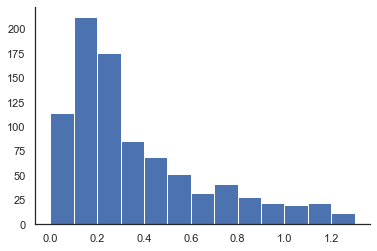

In [25]:
%matplotlib inline
plt.hist(burst_length_4, bins=13, range=(0, 1.3))
sns.despine()

### Burst length probability of histogram

In [26]:
burst_length_normed_1 = 100*hist_dur_1 / burst_length_1.shape[0]
burst_length_normed_2 = 100*hist_dur_2 / burst_length_2.shape[0]
burst_length_normed_3 = 100*hist_dur_3 / burst_length_3.shape[0]
burst_length_normed_4 = 100*hist_dur_4 / burst_length_4.shape[0]
burst_length_normed_5 = 100*hist_dur_5 / burst_length_5.shape[0]

burst_length_normed_1_on = 100*hist_dur_1_on / burst_length_1_on.shape[0]
burst_length_normed_2_on = 100*hist_dur_2_on / burst_length_2_on.shape[0]
burst_length_normed_3_on = 100*hist_dur_3_on / burst_length_3_on.shape[0]
burst_length_normed_4_on = 100*hist_dur_4_on / burst_length_4_on.shape[0]
burst_length_normed_5_on = 100*hist_dur_5_on / burst_length_5_on.shape[0]

np.sum(burst_length_normed_5)

100.0

### (Grand) Mean Duration OFF vs ON 

In [27]:
mean_burst_length_1 = np.mean(burst_length_1)
mean_burst_length_2 = np.mean(burst_length_2)
mean_burst_length_3 = np.mean(burst_length_3)
mean_burst_length_4 = np.mean(burst_length_4)
mean_burst_length_5 = np.mean(burst_length_5)

#ON
mean_burst_length_1_on = np.mean(burst_length_1_on)
mean_burst_length_2_on = np.mean(burst_length_2_on)
mean_burst_length_3_on = np.mean(burst_length_3_on)
mean_burst_length_4_on = np.mean(burst_length_4_on)
mean_burst_length_5_on = np.mean(burst_length_5_on)

print (mean_burst_length_4, mean_burst_length_4_on)

0.4851153039832285 0.15532544378698224


In [28]:
grand_mean = (mean_burst_length_1 + mean_burst_length_2 + mean_burst_length_3 + mean_burst_length_4 + mean_burst_length_5) /5 
grand_mean_on = (mean_burst_length_1_on + mean_burst_length_2_on + mean_burst_length_3_on + mean_burst_length_4_on + mean_burst_length_5_on) /5 
print (grand_mean, grand_mean_on) 

0.30418350850058085 0.1736632493078913


### Normalized power spectral density

In [29]:
power_spectrum_for_channel_1 = np.nanmean(np.squeeze(run_TF[0,:,:]), axis=1)
power_spectrum_for_channel_2 = np.nanmean(np.squeeze(run_TF[1,:,:]), axis=1)
power_spectrum_for_channel_3 = np.nanmean(np.squeeze(run_TF[2,:,:]), axis=1)
power_spectrum_for_channel_4 = np.nanmean(np.squeeze(run_TF[3,:,:]), axis=1)
power_spectrum_for_channel_5 = np.nanmean(np.squeeze(run_TF[4,:,:]), axis=1)

power_spectrum_for_channel_1_on = np.nanmean(np.squeeze(run_TF_on[0,:,:]), axis=1)
power_spectrum_for_channel_2_on = np.nanmean(np.squeeze(run_TF_on[1,:,:]), axis=1)
power_spectrum_for_channel_3_on = np.nanmean(np.squeeze(run_TF_on[2,:,:]), axis=1)
power_spectrum_for_channel_4_on = np.nanmean(np.squeeze(run_TF_on[3,:,:]), axis=1)
power_spectrum_for_channel_5_on = np.nanmean(np.squeeze(run_TF_on[4,:,:]), axis=1)

power_spectrum_for_channel_4.shape

(99,)

In [30]:
npow_1 = power_spectrum_for_channel_1/np.sum(power_spectrum_for_channel_1[4:45] + power_spectrum_for_channel_1[54:95])
npow_2 = power_spectrum_for_channel_2/np.sum(power_spectrum_for_channel_2[4:45] + power_spectrum_for_channel_2[54:95])
npow_3 = power_spectrum_for_channel_3/np.sum(power_spectrum_for_channel_3[4:45] + power_spectrum_for_channel_3[54:95])
npow_4 = power_spectrum_for_channel_4/np.sum(power_spectrum_for_channel_4[4:45] + power_spectrum_for_channel_4[54:95])
npow_5 = power_spectrum_for_channel_5/np.sum(power_spectrum_for_channel_5[4:45] + power_spectrum_for_channel_5[54:95])

npow_1_on = power_spectrum_for_channel_1_on/np.sum(power_spectrum_for_channel_1_on[4:45] + power_spectrum_for_channel_1_on[54:95])
npow_2_on = power_spectrum_for_channel_2_on/np.sum(power_spectrum_for_channel_2_on[4:45] + power_spectrum_for_channel_2_on[54:95])
npow_3_on = power_spectrum_for_channel_3_on/np.sum(power_spectrum_for_channel_3_on[4:45] + power_spectrum_for_channel_3_on[54:95])
npow_4_on = power_spectrum_for_channel_4_on/np.sum(power_spectrum_for_channel_4_on[4:45] + power_spectrum_for_channel_4_on[54:95])
npow_5_on = power_spectrum_for_channel_5_on/np.sum(power_spectrum_for_channel_5_on[4:45] + power_spectrum_for_channel_5_on[54:95])

## Beta power vs burst length

In [31]:
burst_duration_allCh = [burst_length_1,burst_length_2,burst_length_3,burst_length_4,burst_length_5]
burst_duration_allCh_on = [burst_length_1_on,burst_length_2_on,burst_length_3_on,burst_length_4_on,burst_length_5_on]

df_dur = pd.DataFrame(burst_duration_allCh)
df_dur_on = pd.DataFrame(burst_duration_allCh_on) 

df_dur_t=df_dur.T
df_dur_t_on=df_dur_on.T

df_dur_t_r = df_dur_t.rename(columns={0: "secondary somatosensory cortex",1: "secondary/primary somatosensory cortex",2:'primary somatosensory cortex',3:'primary motor cortex',4:'premotor cortex'})
df_dur_t_r_on = df_dur_t_on.rename(columns={0: "secondary somatosensory cortex",1: "secondary/primary somatosensory cortex",2:'primary somatosensory cortex',3:'primary motor cortex',4:'premotor cortex'})

df_dur_t_r_m = df_dur_t_r.assign(med_state='OFF')
df_dur_t_r_m_on = df_dur_t_r_on.assign(med_state='ON')

cdf_dur = pd.concat([df_dur_t_r_m,df_dur_t_r_m_on])
pd_burst_length = pd.melt(cdf_dur,id_vars=['med_state'],var_name=['channel'])
print(pd_burst_length)

     med_state                         channel  value
0          OFF  secondary somatosensory cortex  0.328
1          OFF  secondary somatosensory cortex  0.116
2          OFF  secondary somatosensory cortex  0.020
3          OFF  secondary somatosensory cortex  0.076
4          OFF  secondary somatosensory cortex  0.220
...        ...                             ...    ...
8145        ON                 premotor cortex    NaN
8146        ON                 premotor cortex    NaN
8147        ON                 premotor cortex    NaN
8148        ON                 premotor cortex    NaN
8149        ON                 premotor cortex    NaN

[8150 rows x 3 columns]


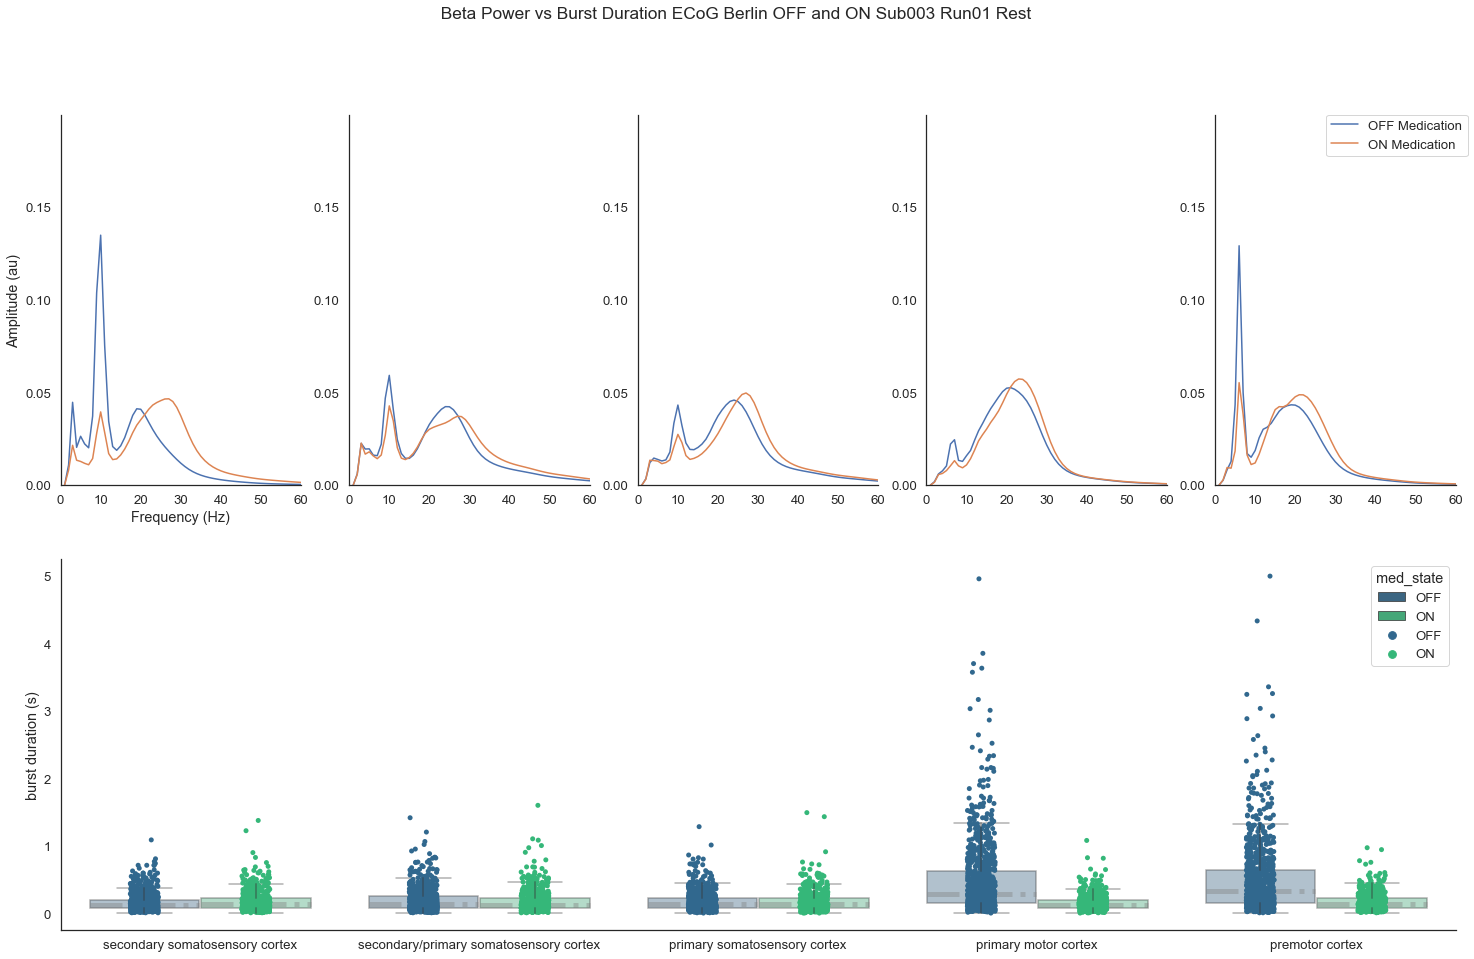

In [32]:
sns.set(style="white", font_scale=1.2)
fig = plt.figure(figsize=(25,15))

ax1 = plt.subplot2grid((2, 5), (0, 0),colspan=1) 
plt.yticks(np.arange(0, 0.2, step=0.05))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (au)')
ax2 = plt.subplot2grid((2, 5), (0, 1),colspan=1)
plt.yticks(np.arange(0, 0.2, step=0.05))
ax3 = plt.subplot2grid((2, 5), (0, 2),colspan=1) 
plt.yticks(np.arange(0, 0.2, step=0.05))
ax4 = plt.subplot2grid((2, 5), (0, 3),colspan=1)
plt.yticks(np.arange(0, 0.2, step=0.05))
ax5 = plt.subplot2grid((2, 5), (0, 4),colspan=1)
plt.yticks(np.arange(0, 0.2, step=0.05))



ax1.set_ylim(0,0.2)
ax2.set_ylim(0,0.2)
ax3.set_ylim(0,0.2)
ax4.set_ylim(0,0.2)
ax5.set_ylim(0,0.2)

ax1.set_xlim(0,60)
ax2.set_xlim(0,60)
ax3.set_xlim(0,60)
ax4.set_xlim(0,60)
ax5.set_xlim(0,60)


ax1.plot(freqs,npow_1,label= 'OFF Medication')
ax1.plot(freqs,npow_1_on,label= 'ON Medication')
ax2.plot(freqs,npow_2,label= 'OFF Medication')
ax2.plot(freqs,npow_2_on,label= 'ON Medication')
ax3.plot(freqs,npow_3,label= 'OFF Medication')
ax3.plot(freqs,npow_3_on,label= 'ON Medication')
ax4.plot(freqs,npow_4,label= 'OFF Medication')
ax4.plot(freqs,npow_4_on,label= 'ON Medication')
ax5.plot(freqs,npow_5,label= 'OFF Medication')
ax5.plot(freqs,npow_5_on,label= 'ON Medication')
plt.legend(bbox_to_anchor=(1.05, 1),loc=1, borderaxespad=0)
ax7 = plt.subplot2grid((2, 6), (1,0),colspan=10) 

alpha_box = 0.4
ax7=sns.boxplot(x='channel', y='value', hue='med_state',data=pd_burst_length, palette="viridis", 
            boxprops=dict(alpha=alpha_box),
           showfliers=False,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           medianprops=dict(linestyle='-.', linewidth=5, color="grey", alpha=alpha_box))

    
ax7 = sns.stripplot(x='channel', y='value', hue='med_state', 
             data=pd_burst_length,palette="viridis", dodge=True, s=5)


plt.ylabel('burst duration (s)')
plt.xlabel('')

plt.suptitle(' Beta Power vs Burst Duration ECoG Berlin OFF and ON Sub003 Run01 Rest ')
sns.despine()

## Cortical beta burst dynamics

### Probability of different burst length OFF vs ON

In [33]:
prob_high_dur_bursts_4=burst_length_normed_4[np.arange(12,100,1)].sum()
prob_high_dur_bursts_4_on=burst_length_normed_4_on[np.arange(12,100,1)].sum()

prob_low_dur_bursts_4 = burst_length_normed_4[np.arange(0,12)]
prob_low_dur_bursts_4_on = burst_length_normed_4_on[np.arange(0,12)]

burst_prob_dur_4 = np.append(prob_low_dur_bursts_4 ,prob_high_dur_bursts_4)
burst_prob_dur_4_on = np.append(prob_low_dur_bursts_4_on ,prob_high_dur_bursts_4_on)

bins_dur=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,'>1.2'] 

In [34]:
df_probdur_4 = pd.DataFrame(data=[bins_dur,burst_prob_dur_4]) 
df_probdur_4_on = pd.DataFrame(data=[bins_dur,burst_prob_dur_4_on]) 

df_probdur_t_4 =df_probdur_4.T
df_probdur_t_4_on =df_probdur_4_on.T

df_probdur_t_r_4 = df_probdur_t_4.rename(columns={0: "Burst Duration (s)",1:'Burst Probability (%)'})
df_probdur_t_r_4_on = df_probdur_t_4_on.rename(columns={0: "Burst Duration (s)",1:'Burst Probability (%)'})

df_probdur_t_r_m_4 = df_probdur_t_r_4.assign(Medication = 'OFF')
df_probdur_t_r_m_4_on = df_probdur_t_r_4_on.assign(Medication = 'ON')

pd_prob_dur_4 = pd.concat([df_probdur_t_r_m_4, df_probdur_t_r_m_4_on])
pd_prob_dur_4

,Burst Duration (s),Burst Probability (%),Medication
0,0.1,11.949686,OFF
1,0.2,22.222222,OFF
2,0.3,18.343816,OFF
3,0.4,8.909853,OFF
4,0.5,7.232704,OFF
5,0.6,5.345912,OFF
6,0.7,3.354298,OFF
7,0.8,4.297694,OFF
8,0.9,2.93501,OFF
9,1.0,2.30608,OFF


### Burst length OFF vs ON

In [35]:
df_dur_4 = pd.DataFrame(burst_length_4)
df_dur_4_on = pd.DataFrame(burst_length_4_on) 

df_dur_4_m = df_dur_4.assign(Location ='ECOG_L4-L5_SMC_AT',Medication = 'OFF')
df_dur_4_m_on = df_dur_4_on.assign(Location ='ECOG_L4-L5_SMC_AT',Medication = 'ON')

df_dur_4_m_r = df_dur_4_m.rename(columns={0: "Burst Duration (s)"})
df_dur_4_m_r_on = df_dur_4_m_on.rename(columns={0: "Burst Duration (s)"})

pd_dur_4 = pd.concat([df_dur_4_m_r, df_dur_4_m_r_on])
pd_dur_4

,Burst Duration (s),Location,Medication
0,1.720,ECOG_L4-L5_SMC_AT,OFF
1,2.460,ECOG_L4-L5_SMC_AT,OFF
2,0.804,ECOG_L4-L5_SMC_AT,OFF
3,0.120,ECOG_L4-L5_SMC_AT,OFF
4,0.152,ECOG_L4-L5_SMC_AT,OFF
...,...,...,...
671,0.272,ECOG_L4-L5_SMC_AT,ON
672,0.212,ECOG_L4-L5_SMC_AT,ON
673,0.076,ECOG_L4-L5_SMC_AT,ON
674,0.056,ECOG_L4-L5_SMC_AT,ON


In [55]:
pw = pd.DataFrame(npow_4)
pw_on = pd.DataFrame(npow_4_on)

pw_a = pw.assign(Location='ECOG-L4-L5_SMC_AT', Medication = 'OFF')
pw_on_a = pw_on.assign(Location='ECOG-L4-L5_SMC_AT', Medication = 'ON')

pw_r = pw_a.rename(columns={0:'Relative spectral power (au)'}) 
pw_r_on = pw_on_a.rename(columns={0:'Relative spectral power (au)'}) 

pw_c = pd.concat([pw_r, pw_r_on])

In [58]:
pw_c.to_csv('M1_Relative_Power.csv')

In [56]:
pw_c

,Relative spectral power (au),Location,Medication
0,0.000015,ECOG-L4-L5_SMC_AT,OFF
1,0.001856,ECOG-L4-L5_SMC_AT,OFF
2,0.006020,ECOG-L4-L5_SMC_AT,OFF
3,0.007725,ECOG-L4-L5_SMC_AT,OFF
4,0.010386,ECOG-L4-L5_SMC_AT,OFF
...,...,...,...
94,0.000066,ECOG-L4-L5_SMC_AT,ON
95,0.000062,ECOG-L4-L5_SMC_AT,ON
96,0.000060,ECOG-L4-L5_SMC_AT,ON
97,0.000057,ECOG-L4-L5_SMC_AT,ON


### Biomarker comparison

NameError: name 'freqs' is not defined

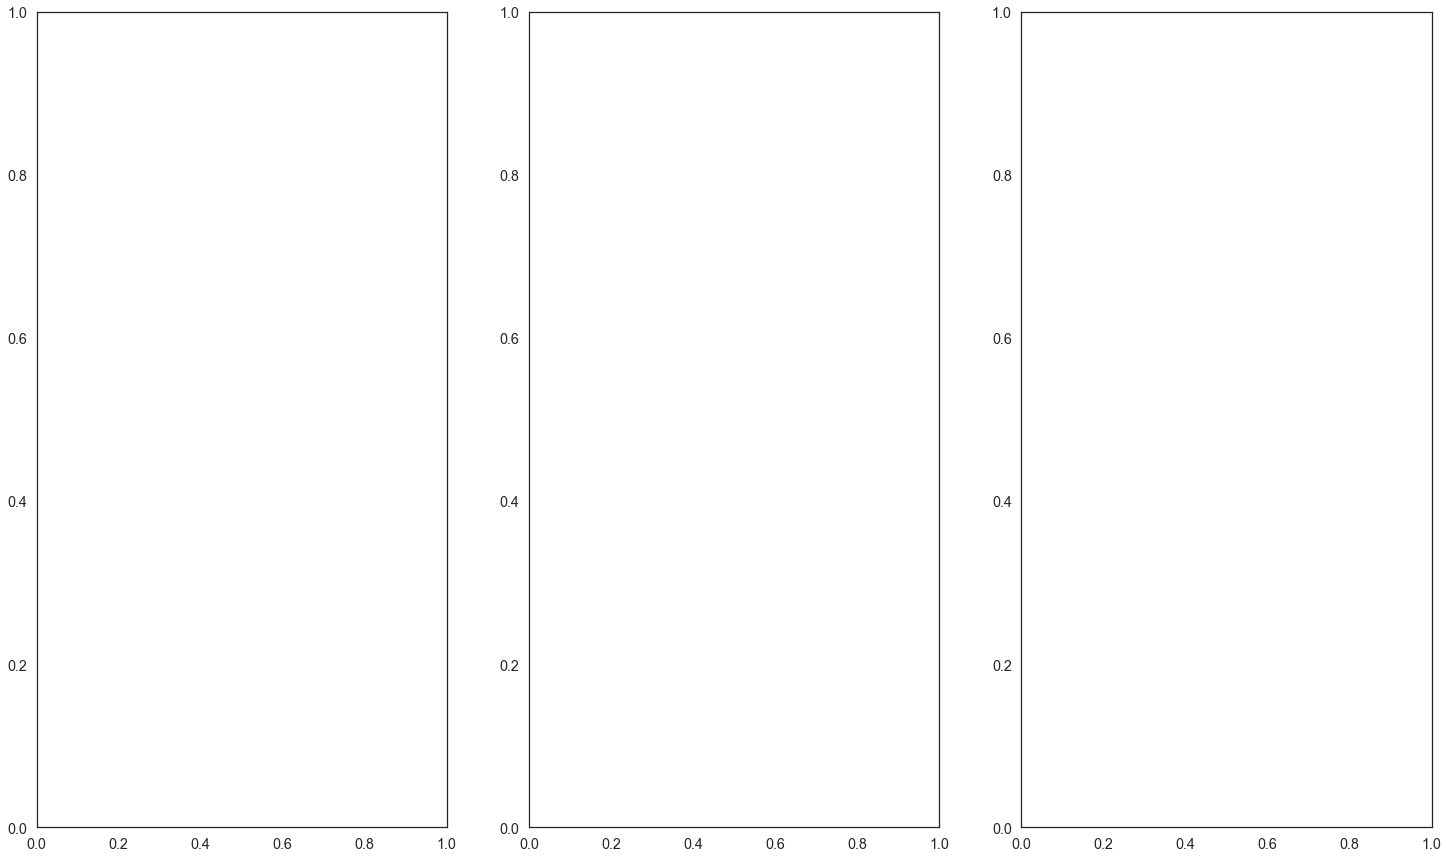

In [7]:
sns.set(style="white", font_scale=1.3)
fig,ax = plt.subplots(1,3, figsize=(25,15),)

plt.subplot(131)
plt.plot(freqs,npow_4,label= 'OFF ',linewidth=4)
plt.plot(freqs,npow_4_on,label= 'ON',linewidth=4)
plt.xlim(0,60)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Relative spectral power (au)')
plt.legend(title='Medication', fontsize=15,title_fontsize=15)
        
plt.subplot(132)           
alpha_box=0.3
sns.barplot(data=pd_prob_dur_4, x='Burst Duration (s)', y='Burst Probability (%)', hue='Medication') 
plt.legend(title='Medication', fontsize=15,title_fontsize=15)


plt.subplot(133)
alpha_box = 0.4
g = sns.boxplot(x='Location', y='Burst Duration (s)', hue='Medication',data=pd_dur_4,         
           showfliers=False,meanline=dict(color='r'), showmeans=True,
           whiskerprops={'linewidth':2, "zorder":10, "alpha":alpha_box},
           capprops={"alpha":alpha_box},
           meanprops=dict(linestyle='-.', linewidth=5,color='r'))
plt.xlabel('Primary Motor Cortex')
plt.legend(title='Medication', fontsize=15,title_fontsize=15)

for n, ax in enumerate(ax):   
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=30, weight='bold')
    
sns.despine()

In [41]:
import csv

In [43]:
pd_prob_dur_4.to_csv('M1_BurstDynamics.csv')

In [61]:
pd_dur_4.to_csv('M1.csv')

In [62]:
pd_dur_4

,Burst Duration (s),Location,Medication
0,1.720,ECOG_L4-L5_SMC_AT,OFF
1,2.460,ECOG_L4-L5_SMC_AT,OFF
2,0.804,ECOG_L4-L5_SMC_AT,OFF
3,0.120,ECOG_L4-L5_SMC_AT,OFF
4,0.152,ECOG_L4-L5_SMC_AT,OFF
...,...,...,...
671,0.272,ECOG_L4-L5_SMC_AT,ON
672,0.212,ECOG_L4-L5_SMC_AT,ON
673,0.076,ECOG_L4-L5_SMC_AT,ON
674,0.056,ECOG_L4-L5_SMC_AT,ON
